In [1]:
%matplotlib inline
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func, and_ 

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite", echo=False)

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)
Base.classes.keys()

['station', 'measurement']

In [6]:
insp = inspect(engine)
columns_meas = insp.get_columns('measurement')
for c in columns_meas:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
insp = inspect(engine)
columns_stat = insp.get_columns('station')
for c in columns_stat:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print('Most recent Date {}'.format(recent_date))


Most recent Date ('2017-08-23',)


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
year_back = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print('Last Year Date {}'.format(year_back))

Last Year Date 2016-08-23


In [13]:
# Perform a query to retrieve the date and precipitation scores - due to multiple readings per day calculate the average per day
scores = session.query(Measurement.date, func.avg(Measurement.prcp)).filter(Measurement.date > year_back). \
group_by(Measurement.date).all()
scores[0:10]

[('2016-08-24', 1.5549999999999997),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.06399999999999999),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.6359999999999999),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05)]

In [14]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
column_names=["Date","Average_Precipitation"]
results_df = pd.DataFrame(scores, columns=column_names)

# Sort the dataframe by date
results_df = results_df.sort_values(by="Date", ascending=False)
results_df.set_index("Date", inplace=True)
results_df.head()

,Average_Precipitation
Date,
2017-08-23,0.132500
2017-08-22,0.166667
2017-08-21,0.193333
2017-08-20,0.005000
2017-08-19,0.030000


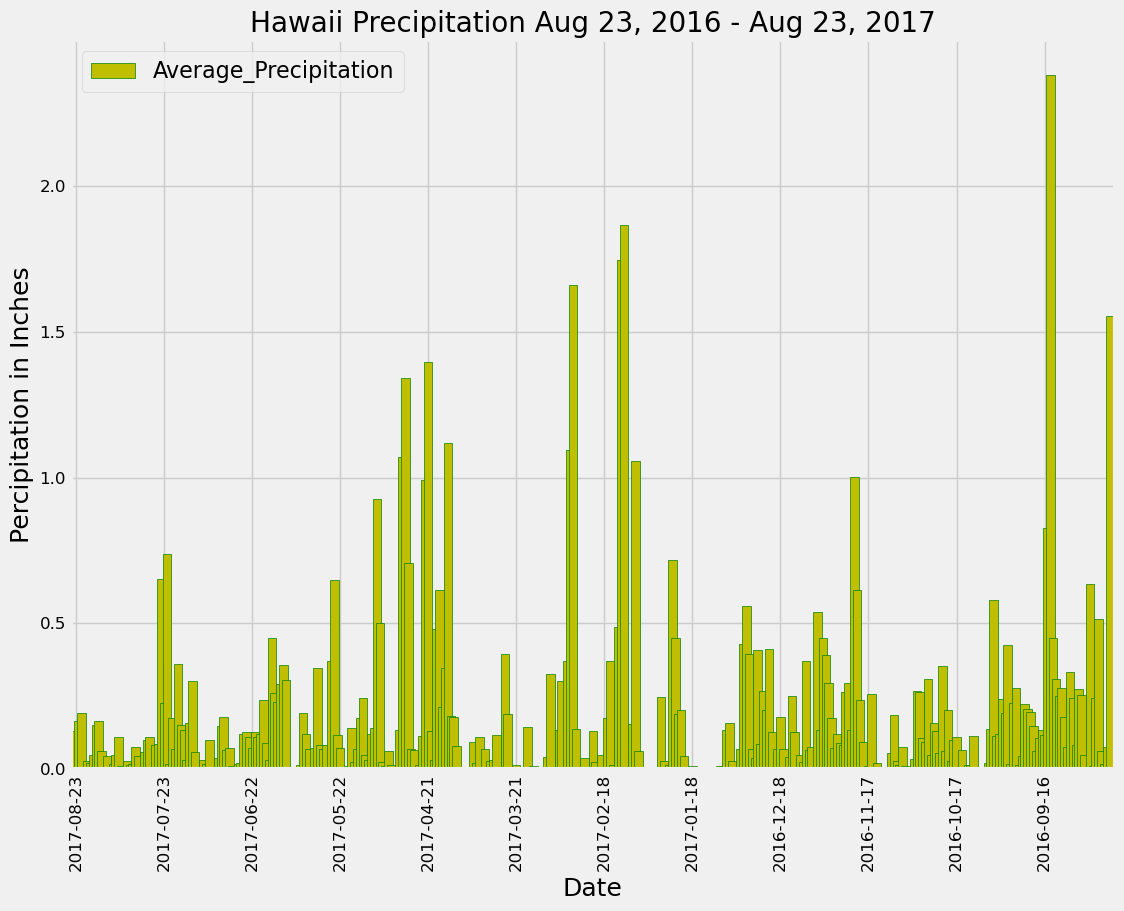

In [28]:
# Use Pandas Plotting with Matplotlib to plot the data
bar_chart = results_df.plot(kind='bar', width=3, color='y', edgecolor='g', rot=90, figsize=(12,9))
bar_chart.tick_params(axis='y', labelsize = 12)
bar_chart.tick_params(axis='x', labelsize = 12)
plt.legend(loc='best', fontsize="16")
plt.title("Hawaii Precipitation Aug 23, 2016 - Aug 23, 2017" , size=20)
plt.locator_params(axis='x', nbins=12)
plt.xlabel("Date", size=18)
plt.ylabel("Percipitation in Inches", size=18)
plt.savefig("Precipitation Bar Chart.png")
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data    used - https://www.geeksforgeeks.org/
#   I found a cool comand - Pandas describe() is used to view some basic statistical details like percentile, mean, std, etc. of a data frame 
results_df.describe()

,Average_Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
station_cnt = session.query(Station.id).count()
print(f'There are {station_cnt} distinct stations in the data set')

There are 9 distinct stations in the data set


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)). \
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), 
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == active_stations[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

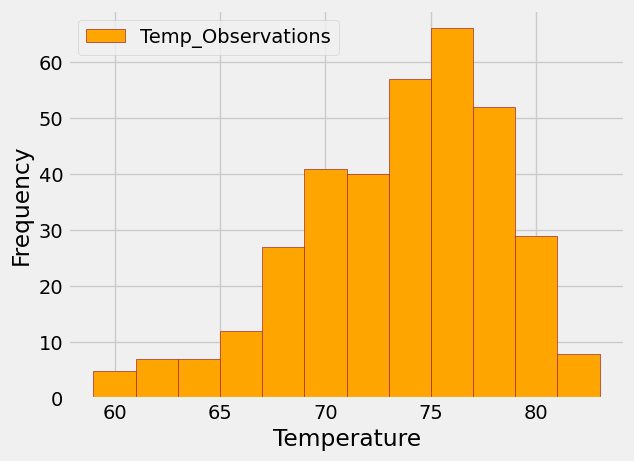

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_obs = session.query(Measurement.date, Measurement.tobs).\
                        filter(and_(Measurement.date>year_back, Measurement.station==active_stations[0][0])).all()
# make into Data Frame

observation_df = pd.DataFrame(max_obs)
observation_df.columns=["Date","Temp_Observations"]
observation_df.head()
#histogram
observation_df.plot.hist(bins=12, ylabel='Frequency', xlabel='Temperature', color='Orange',edgecolor='brown')
plt.savefig("Temperature observations Bar Chart.png")

In [21]:
# This is extra For all stations calculate the lowest, highest, and average temperature.
start_date = '2016-08-24'
end_date = '2017-08-23'
all_stats = session.query(Measurement.station, 
        func.min(Measurement.tobs), 
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)).\
        filter(and_(Measurement.date >= start_date, Measurement.date <= end_date)).\
        group_by(Measurement.station).all()
all_stats

[('USC00513117', 61.0, 82.0, 73.26900584795321),
 ('USC00514830', 63.0, 83.0, 77.15131578947368),
 ('USC00516128', 58.0, 82.0, 72.08620689655173),
 ('USC00517948', 62.0, 87.0, 74.75274725274726),
 ('USC00519281', 59.0, 83.0, 73.0968660968661),
 ('USC00519397', 60.0, 87.0, 75.19444444444444),
 ('USC00519523', 60.0, 85.0, 76.96130952380952)]

# Close Session

In [22]:
# Close Session
session.close()